In [1]:
import numpy as np

from utils import DatasetReader
from transformers import AutoTokenizer, AutoModel, RobertaModel, RobertaTokenizerFast
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc

torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Prepare model

In [3]:
class Model(nn.Module):
    def __init__(self, pretrained_name='distilroberta-base'):
        super(Model, self).__init__()

        self.tokenizer = RobertaTokenizerFast.from_pretrained(pretrained_name)
        self.model = RobertaModel.from_pretrained(pretrained_name)

        self.embedding_size = self.model.embeddings.word_embeddings.embedding_dim

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.embedding_size * 2, out_features=self.embedding_size),
            nn.Dropout(p=0.4),
            nn.ReLU(),

            nn.Linear(in_features=self.embedding_size, out_features=self.embedding_size // 2),
            nn.Dropout(p=0.3),
            nn.ReLU(),

            nn.Linear(in_features=self.embedding_size // 2, out_features=5),
            nn.ReLU(),
        )

    def forward(self, x: list[str]):
        encoded_batch = self.tokenizer(x, padding=True, truncation=True, return_tensors='pt')
        encoded_batch.to(self.model.device)

        out = self.model(**encoded_batch).last_hidden_state

        out = torch.concatenate([out[:, 0, :], out[:, -1, :]], dim=1)

        out = self.fc(out)

        del encoded_batch
        return out


Model()(['hello', 'world', 'I can put so many words here to explore how does the tokes work']).shape

torch.Size([3, 5])

## Load dataset

In [4]:
class TextDataset(Dataset):
    def __init__(self, data):
        super(TextDataset, self).__init__()
        self.data = np.array(data.iloc[:, 0])
        self.labels = np.array(data.iloc[:, 1])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [5]:
test_data, train_data = DatasetReader(encode_labels=True, test_size=0.2).read_dirs('../data')
test_data, train_data = TextDataset(test_data), TextDataset(train_data)
len(test_data), len(train_data)

(563, 2252)

In [6]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

## Training/evaluating the model

In [7]:
def train(model, loader, optimizer, criterion, device, _tqdm=False):
    model = model.to(device)
    model.train()

    train_loss = 0

    rng = tqdm(loader) if _tqdm else loader
    for batch in rng:
        data, label = batch
        label = label.to(device)

        loss = criterion(model(data), label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        del label
        torch.cuda.empty_cache()
        gc.collect()
    return train_loss


def test(model, loader, device, _tqdm=False):
    correct_samples = 0
    all_samples = 0

    with torch.no_grad():
        for batch in loader:
            data, label = batch
            label = label.to(device)
            output = model(data)
            prediction = torch.argmax(output, dim=1)
            correct_samples += sum(label == prediction)
            all_samples += len(label)

            torch.cuda.empty_cache()
            gc.collect()
    return float(correct_samples / all_samples)


In [8]:
criterion = nn.CrossEntropyLoss()
model = Model(pretrained_name='distilroberta-base').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
train_accuracies = []
test_accuracies = []

In [9]:
for epoch in (bar := tqdm(range(20))):
    train_loss = train(model, train_loader, optimizer, criterion, device, _tqdm=False)
    train_losses.append(train_loss)

    train_acc = test(model, train_loader, device)
    test_acc = test(model, test_loader, device)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    bar.set_postfix({'train_accuracy': train_acc, 'test_accuracy': test_acc})

  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt



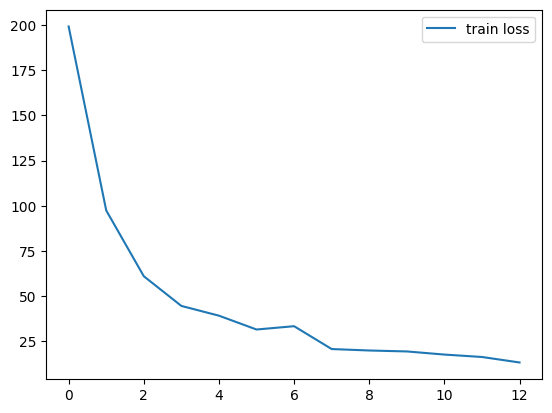

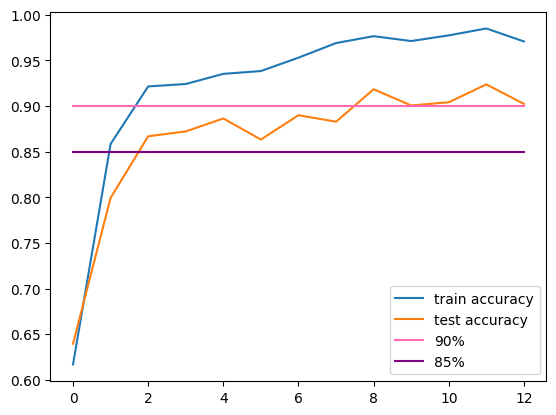

In [9]:
plt.plot(train_losses, label='train loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.plot([0.9] * len(test_accuracies), label='90%', c='hotpink')
plt.plot([0.85] * len(test_accuracies), label='85%', c='purple')
plt.legend()
plt.show()